# 多层感知机

## 隐藏层

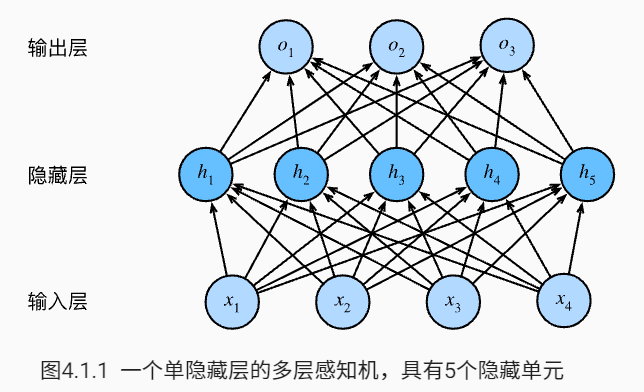

每个输入都会影响隐藏层中的每个神经元， 而隐藏层中的每个神经元又会影响输出层中的每个神经元。

### 从线性到非线性

如果不加激活函数，不管加多少层，始终是线性模型。
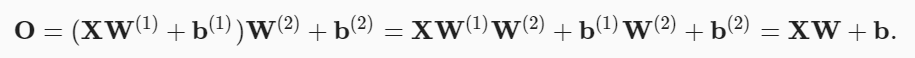

### 通用近似定理

就算是只有一层隐藏层，只有神经元个数足够多以及权重正确，就可以拟合任何函数。但是更建议增加层数，更容易逼近许多函数。

## 激活函数

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

### Relu函数

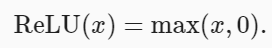

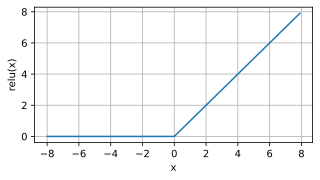

In [2]:
x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(),y.detach(),'x','relu(x)',figsize=(5,2.5))

In [3]:
x.detach().type()

'torch.FloatTensor'

In [4]:
type(x.detach().numpy())

numpy.ndarray

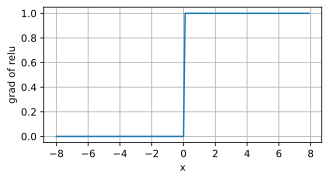

In [5]:
y.backward(torch.ones_like(x),retain_graph=True) 
# retain_graph的作用，假如两个层都公用一个神经网络的参数但是有两个loss的输出，因此需要retain_graph参数为True去保留中间参数从而两个loss的backward()不会相互影响。
d2l.plot(x.detach(),x.grad,'x','grad of relu',figsize=(5,2.5))

改进：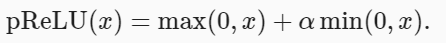

负值也能通过

### sigmoid函数 

sigmoid:平滑，可导，阈值单元。

现在还常用来作二分类。

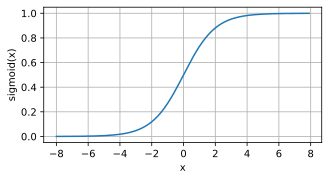

In [6]:
y = torch.sigmoid(x)
d2l.plot(x.detach(),y.detach(),'x','sigmoid(x)',figsize=(5,2.5))

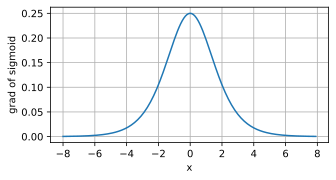

In [7]:
# sigmoid导数可视化
x.grad.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(),x.grad,'x','grad of sigmoid',figsize=(5,2.5))

### tanh函数 

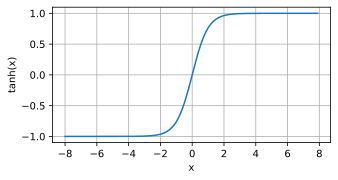

In [8]:
y = torch.tanh(x)
d2l.plot(x.detach(),y.detach(),'x','tanh(x)',figsize=(5,2.5))

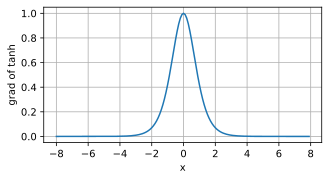

In [9]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

### 总结 

多层感知机在输出层和输入层之间增加一个或多个全连接隐藏层，并通过激活函数转换隐藏层的输出。

常用的激活函数包括ReLU函数、sigmoid函数和tanh函数。

## 多层感知机从零开始实现

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

C:\ProgramData\Anaconda3\envs\d21-zh\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 初始化模型参数 

In [11]:
num_inputs,num_outputs,num_hiddens = 784,10,256
# 一层隐藏层,不算输入层，共两层
# randn是标准正态分布
W1 = nn.Parameter(torch.randn(num_inputs,num_hiddens,requires_grad=True)*0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens,requires_grad=True))
W2 = nn.Parameter(torch.randn(num_hiddens,num_outputs,requires_grad=True)*0.01)
b2 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1,b1,W2,b2]

### 激活函数 

In [12]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X,a)

### 模型 

In [13]:
def net(X):
    X = X.reshape(-1,num_inputs)
    H = relu(X@W1+b1) # 这里“@”代表矩阵乘法
    return H@W2 + b2

### 损失函数

In [14]:
loss = nn.CrossEntropyLoss() # crossentropy loss input 为 (N,C)维

### 训练

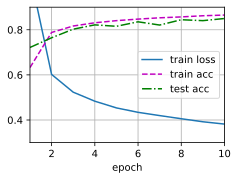

In [15]:
# 与softmax一模一样
num_epochs,lr = 10,0.1
updater = torch.optim.SGD(params,lr=lr)
d2l.train_ch3(net,train_iter,test_iter,loss,num_epochs,updater)

## 多层感知机简洁实现 

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

In [19]:
net = nn.Sequential(nn.Flatten(),
             nn.Linear(784,256),
             nn.ReLU(),
             nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight,std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=10, bias=True)
)

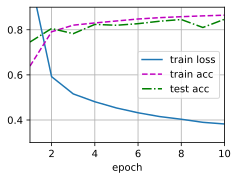

In [20]:
batch_size,lr,num_epochs = 256,0.1,10

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(),lr=lr)

train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 模型选择、欠拟合和过拟合

### 训练误差和泛化误差

训练集：训练误差
验证集：泛化误差

### 模型选择

在确定模型的超参数前，尽量不用到测试集，如果在模型选择阶段就用了测试集，容易过拟合。所以需要额外设置验证集。

在训练数据集有限的情况下，采取k-fold交叉验证，

### 过拟合或欠拟合

- 模型复杂度：模型参数数量，可解释性，表达能力。
- 数据量的大小。

做一个小实验，多项式模型预测，随着模型复杂度的变化，过拟合和欠拟合发生的状况。

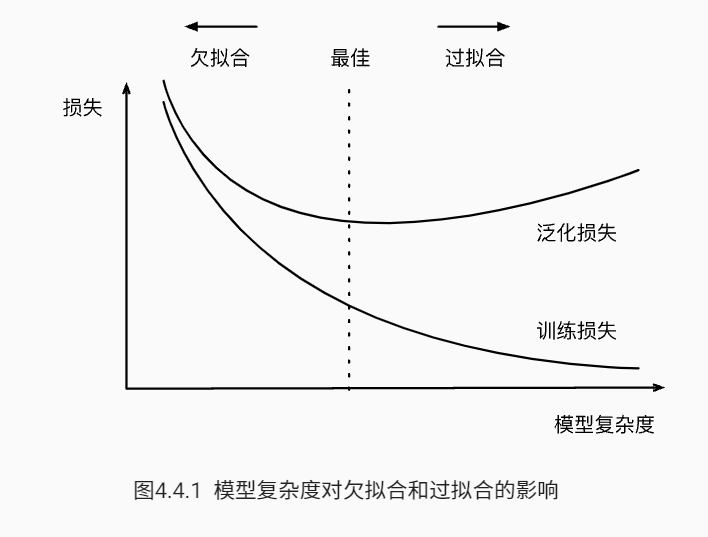

### 多项式回归

In [21]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

#### 生产数据集

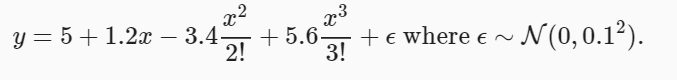

噪声项 ϵ 服从均值为0且标准差为0.1的正态分布。 在优化的过程中，我们通常希望避免非常大的梯度值或损失值。 这就是我们将特征从 xi 调整为 xii! 的原因， 这样可以避免很大的 i 带来的特别大的指数值。 我们将为训练集和测试集各生成100个样本。

In [22]:
max_degree = 20
n_train,n_test = 100,100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size=(n_train+n_test,1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# poly_features维度：(n_train+n_test,max_degree)
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape) # scale是标准差

In [23]:
# NumPyndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.4681],
         [0.3220]]),
 tensor([[1.0000e+00, 4.6813e-01, 1.0957e-01, 1.7098e-02, 2.0010e-03, 1.8734e-04,
          1.4617e-05, 9.7751e-07, 5.7200e-08, 2.9752e-09, 1.3928e-10, 5.9273e-12,
          2.3123e-13, 8.3264e-15, 2.7842e-16, 8.6890e-18, 2.5422e-19, 7.0005e-21,
          1.8206e-22, 4.4857e-24],
         [1.0000e+00, 3.2199e-01, 5.1838e-02, 5.5638e-03, 4.4787e-04, 2.8842e-05,
          1.5478e-06, 7.1196e-08, 2.8655e-09, 1.0252e-10, 3.3010e-12, 9.6626e-14,
          2.5927e-15, 6.4217e-17, 1.4769e-18, 3.1704e-20, 6.3802e-22, 1.2084e-23,
          2.1617e-25, 3.6634e-27]]),
 tensor([5.4569, 5.3706]))

#### 对模型进行训练和测试

In [24]:
def evaluate_loss(net,data_iter,loss):
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X,y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric.data[0] / metric.data[1]

In [38]:
def train_epoch_ch3(net,train_iter,loss,updater): #@save
    # 将模型设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater,torch.optim.Optimizer):
            # torch.optim.Optimizer:优化权重的类，其他所有优化器都是它的基类
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.sum().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])

In [39]:
# d2l.load_array
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none') # 均方误差；去掉reduction='none'，则默认取均值
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.001)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

#### 三阶多项式函数拟合(正态)

weight: [[ 5.007602   1.228711  -3.4185798  5.558798 ]]


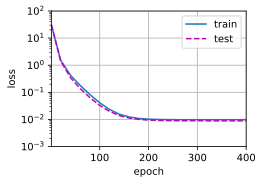

In [40]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!; 每一阶是一个新的特征
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

#### 线性函数拟合(欠拟合)

weight: [[3.2375174 4.2725515]]


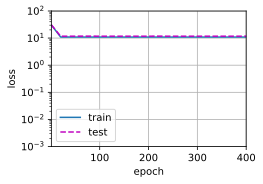

In [41]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

#### 高阶多项式函数拟合(过拟合)

weight: [[ 5.013269    1.3071517  -3.4749167   5.154098    0.14084138  1.0769396
   0.15021116  0.01719197 -0.15648487  0.07186741  0.2244688   0.10876294
   0.09714266 -0.19370764 -0.1614449  -0.12506333 -0.09880833 -0.21384712
  -0.10463173  0.00725491]]


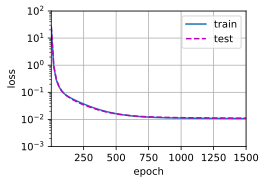

In [42]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

？我不理解，这怎么过拟合了，不是挺好的？？？

### 总结 

- 欠拟合是指模型无法继续减少训练误差。过拟合是指训练误差远小于验证误差。

- 由于不能基于训练误差来估计泛化误差，因此简单地最小化训练误差并不一定意味着泛化误差的减小。机器学习模型需要注意防止过拟合，即防止泛化误差过大。

- 验证集可以用于模型选择，但不能过于随意地使用它。

- 我们应该选择一个复杂度适当的模型，避免使用数量不足的训练样本。